<a href="https://colab.research.google.com/github/cswcjt/CodingTest_study/blob/main/oil_cjt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. Data load

In [1]:
# 데이터분석 4종 세트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
base_path = "/content/drive/MyDrive/fastcamp/datas/open/"
train = pd.read_csv(base_path + "train.csv", encoding='cp949')
test = pd.read_csv(base_path + "test.csv", encoding='cp949')
submission = pd.read_csv(base_path + "sample_submission.csv", encoding='cp949')

In [4]:
print("Train shape : ", train.shape)
print("Test shape : ", test.shape)

Train shape :  (14095, 54)
Test shape :  (6041, 19)


In [5]:
test.head()

,ID,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,ANONYMOUS_2,AG,CO,CR,CU,FE,H2O,MN,MO,NI,PQINDEX,TI,V,V40,ZN
0,TEST_0000,COMPONENT1,2192,2016,200,0,0,0,1,12,0.0,0,0,0,10,0,0,91.3,1091
1,TEST_0001,COMPONENT3,2794,2011,200,0,0,2,1,278,0.0,3,0,0,2732,1,0,126.9,12
2,TEST_0002,COMPONENT2,1982,2010,200,0,0,0,16,5,0.0,0,0,0,11,0,0,44.3,714
3,TEST_0003,COMPONENT3,1404,2009,200,0,0,3,4,163,0.0,4,3,0,8007,0,0,142.8,94
4,TEST_0004,COMPONENT2,8225,2013,200,0,0,0,6,13,0.0,0,0,0,16,0,0,63.4,469


### 2. EDA : 목적 -> 데이터에 대한 이해

- 데이터에서 찾아야 하는 기초적인 내용들을 확인합니다.

- class imbalance, target distribution, outlier, correlation을 확인합니다.

1) Target Variable : "y" is the variable we need to predict. 
- 0 means oil condition is normal
- 1 means oil condition is abnormal

In [6]:
train.Y_LABEL.value_counts()

0    12892
1     1203
Name: Y_LABEL, dtype: int64

<Figure size 576x432 with 0 Axes>

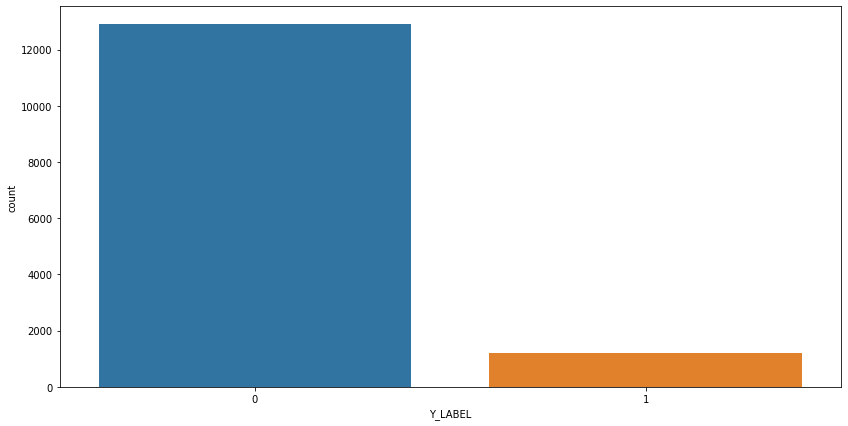

In [7]:
plt.figure(figsize=(8,6))
plt.figure(figsize = (14, 7))
sns.countplot(data = train, x = train.Y_LABEL)
plt.show()

2) Now let us have a look at the data type of all the variables present in the dataset.
- 결과 : 

int64 -> 31

categorical columns -> 2

float64 -> 21 

In [8]:
dtype_df = train.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"] 
dtype_df.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,int64,31
1,float64,21
2,object,2


In [9]:
dtype_df.loc[dtype_df["Column Type"] == "object",:] # -> "ID" and "COMPONENT_ARBITRARY" are the categorical columns.

,Count,Column Type
0,ID,object
1,COMPONENT_ARBITRARY,object


In [10]:
train.COMPONENT_ARBITRARY.value_counts().reset_index()

,index,COMPONENT_ARBITRARY
0,COMPONENT3,7050
1,COMPONENT1,3890
2,COMPONENT2,2316
3,COMPONENT4,839


Text(0.5, 1.0, 'Y_label')

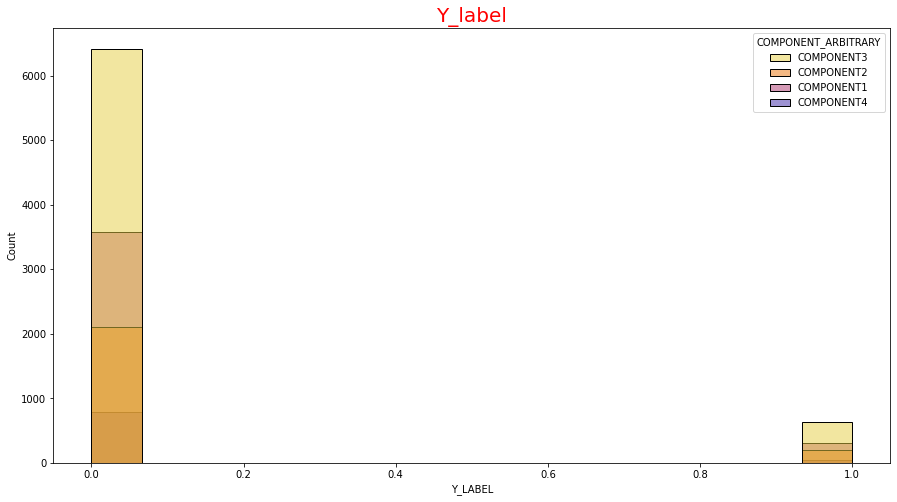

In [11]:
plt.figure(figsize = (15,8))
sns.histplot(x = "Y_LABEL", data = train, hue = "COMPONENT_ARBITRARY", palette='CMRmap_r')
plt.title("Y_label", size=20, color = "red")

3) Missing values: Let us now check for the missing values.
- 결과 : nan값 많다 
- nan값 많은 컬럼의 경우 test data set에는 안들어 있는 경우 드랍 또는 0으로 채우자. 

In [12]:
#train.isnull().sum(axis=0).reset_index()
missing_df = train.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
mark = missing_df['missing_count']>0
missing_df = missing_df.loc[mark]
missing_df = missing_df.sort_values(by='missing_count')
missing_df

,column_name,missing_count
12,CD,1394
25,K,2299
23,FUEL,10205
21,FTBN,10205
20,FSO4,10205
39,SOOTPERCENTAGE,10205
18,FOPTIMETHGLY,10205
17,FNOX,10205
16,FH2O,10205
19,FOXID,10205


In [13]:
train = train.fillna(0)
test = test.fillna(0)

4) Integer Columns Analysis

In [14]:
# unique_values_dict = {}
# for col in train.columns:
#     if col not in ["ID", "Y_LABEL", "COMPONENT_ARBITRARY"]:
#         unique_value = str(np.sort(train[col].unique()).tolist())
#         tlist = unique_values_dict.get(unique_value, []) # dic.get(key, value) -> key에 대해서 빈 리스트를 만들어준다.
#         tlist.append(col) # 같은 key값인 경우 리스트가 append된다.  
#         unique_values_dict[unique_value] = tlist[:] # 리스트가 완성되면 dic에 저장한다. 
#         #print(unique_values_dict)
# for unique_val, columns in unique_values_dict.items():
#     print("Columns containing the unique values : ",unique_val)
#     print(columns)
#     print("--------------------------------------------------")

### 3. Data Preparation
- 전력 사용량을 기준으로 그룹을 나누어보자 : 결과 언급하면 총 4개의 그룹 만들었다.
- X_train & X_val data에 groupby를 이용해 4개의 데이터셋을 만들었다.
- y_train & y_val data는 전력량 정보인 target이 없다. 따라서 인덱스 정보를 가지고 4개의 데이터셋을 만들어준다.

6) 중요한 피처들을 그룹별로 뽑아보자 -> Random Forest 적용 후 



In [15]:
from sklearn.model_selection import train_test_split
# X = train.drop(columns = "Y_LABEL")
# y = train.Y_LABEL
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# print('분리 전 shape : ', X.shape)
# print('X_train의 shape : ', X_train.shape)
# print('X_test의 shape : ',X_test.shape)

print(len(train.loc[(train.COMPONENT_ARBITRARY == "COMPONENT1") & (train.Y_LABEL == 0)]))
print(len(train.loc[(train.COMPONENT_ARBITRARY == "COMPONENT1") & (train.Y_LABEL == 1)]))
print("-" * 5)
print(len(train.loc[(train.COMPONENT_ARBITRARY == "COMPONENT2") & (train.Y_LABEL == 0)]))
print(len(train.loc[(train.COMPONENT_ARBITRARY == "COMPONENT2") & (train.Y_LABEL == 1)]))
print("-" * 5)
print(len(train.loc[(train.COMPONENT_ARBITRARY == "COMPONENT3") & (train.Y_LABEL == 0)]))
print(len(train.loc[(train.COMPONENT_ARBITRARY == "COMPONENT3") & (train.Y_LABEL == 1)]))
print("-" * 5)
print(len(train.loc[(train.COMPONENT_ARBITRARY == "COMPONENT4") & (train.Y_LABEL == 0)]))
print(len(train.loc[(train.COMPONENT_ARBITRARY == "COMPONENT4") & (train.Y_LABEL == 1)]))

3578
312
-----
2110
206
-----
6415
635
-----
789
50


In [16]:
train

,ID,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,SAMPLE_TRANSFER_DAY,ANONYMOUS_2,AG,AL,B,BA,...,U25,U20,U14,U6,U4,V,V100,V40,ZN,Y_LABEL
0,TRAIN_00000,COMPONENT3,1486,2011,7,200,0,3,93,0,...,0.0,0.0,0.0,0.0,0.0,0,0.0,154.0,75,0
1,TRAIN_00001,COMPONENT2,1350,2021,51,375,0,2,19,0,...,2.0,4.0,6.0,216.0,1454.0,0,0.0,44.0,652,0
2,TRAIN_00002,COMPONENT2,2415,2015,2,200,0,110,1,1,...,0.0,3.0,39.0,11261.0,41081.0,0,0.0,72.6,412,1
3,TRAIN_00003,COMPONENT3,7389,2010,2,200,0,8,3,0,...,0.0,0.0,0.0,0.0,0.0,0,0.0,133.3,7,0
4,TRAIN_00004,COMPONENT3,3954,2015,4,200,0,1,157,0,...,0.0,0.0,0.0,0.0,0.0,0,0.0,133.1,128,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14090,TRAIN_14090,COMPONENT3,1616,2014,8,200,0,2,201,1,...,0.0,0.0,0.0,0.0,0.0,0,0.0,135.4,16,0
14091,TRAIN_14091,COMPONENT1,2784,2013,2,200,0,3,85,0,...,0.0,0.0,0.0,0.0,0.0,0,14.5,117.5,1408,0
14092,TRAIN_14092,COMPONENT3,1788,2008,9,550,0,6,0,1,...,0.0,0.0,0.0,0.0,0.0,0,0.0,54.0,1301,0
14093,TRAIN_14093,COMPONENT2,2498,2009,19,550,0,2,4,0,...,7.0,8.0,100.0,1625.0,18890.0,0,0.0,44.3,652,0


In [17]:
def grouping_df(target_df, categorical_feature) : 
    #print(df[categorical_feature])
    grouped_list = []
    for standard in list(target_df[categorical_feature].unique()) : 
        print(f"dividing my df on {standard}")
        grouped_list.append(target_df.loc[target_df.COMPONENT_ARBITRARY ==  standard, ].drop(columns = categorical_feature))
    return grouped_list

In [18]:
test = grouping_df(train, "COMPONENT_ARBITRARY")

dividing my df on COMPONENT3
dividing my df on COMPONENT2
dividing my df on COMPONENT1
dividing my df on COMPONENT4


In [19]:
test[0]

,ID,ANONYMOUS_1,YEAR,SAMPLE_TRANSFER_DAY,ANONYMOUS_2,AG,AL,B,BA,BE,...,U25,U20,U14,U6,U4,V,V100,V40,ZN,Y_LABEL
0,TRAIN_00000,1486,2011,7,200,0,3,93,0,0,...,0.0,0.0,0.0,0.0,0.0,0,0.0,154.0,75,0
3,TRAIN_00003,7389,2010,2,200,0,8,3,0,0,...,0.0,0.0,0.0,0.0,0.0,0,0.0,133.3,7,0
4,TRAIN_00004,3954,2015,4,200,0,1,157,0,0,...,0.0,0.0,0.0,0.0,0.0,0,0.0,133.1,128,0
5,TRAIN_00005,2061,2008,4,550,0,3,8,0,0,...,0.0,0.0,0.0,0.0,0.0,0,0.0,69.7,1015,0
6,TRAIN_00006,1416,2015,7,616,0,0,21,0,0,...,0.0,0.0,0.0,0.0,0.0,0,0.0,148.5,24,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14082,TRAIN_14082,3060,2010,2,200,0,2,3,0,0,...,0.0,0.0,0.0,0.0,0.0,0,0.0,140.0,35,1
14086,TRAIN_14086,1637,2008,16,487,0,11,99,2,0,...,0.0,0.0,0.0,0.0,0.0,0,0.0,152.6,21,1
14088,TRAIN_14088,1311,2010,6,511,0,0,20,0,0,...,0.0,0.0,0.0,0.0,0.0,0,0.0,128.9,20,0
14090,TRAIN_14090,1616,2014,8,200,0,2,201,1,0,...,0.0,0.0,0.0,0.0,0.0,0,0.0,135.4,16,0


In [20]:
from imblearn.over_sampling import RandomOverSampler
from scipy.stats import skew, kurtosis

In [21]:
print(len(train[train.Y_LABEL == 0])) # 정상
print(len(train[train.Y_LABEL == 1])) # 비정상

12892
1203


In [22]:
independent_variable = train.drop(columns = "Y_LABEL", )
dependent_variable = train.Y_LABEL
print(independent_variable.shape, dependent_variable.shape)

(14095, 53) (14095,)


In [25]:
# 독립변수, 종속변수 지정
independent_variable = train.drop(columns = ["Y_LABEL", "COMPONENT_ARBITRARY"])
dependent_variable = train.Y_LABEL
print(independent_variable.shape, dependent_variable.shape)

# summarize class distribution
print("before oversampling :")
#print(Counter(dependent_variable))
print("skewness", skew(dependent_variable)) 
print("kurtosis", kurtosis(dependent_variable, fisher=True)) 

# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy='minority')
# fit and apply the transform
X_over, y_over = oversample.fit_resample(independent_variable, dependent_variable)

# summarize class distribution
print("\n" + "after oversampling :")
#print( Counter(y_over))
print("skewness", skew(y_over)) 
print("kurtosis", kurtosis(y_over, fisher=True)) 

(14095, 52) (14095,)
before oversampling :
skewness 2.9681401013583395
kurtosis 6.809855661291488

after oversampling :
skewness 0.0
kurtosis -2.0


In [31]:
from collections import Counter
from sklearn.model_selection import train_test_split as tts
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

pca = PCA()
smt = SMOTE(random_state=42)
rfc = RFC()
pipeline = Pipeline([('smt', smt), ('pca', pca), ('rfc', rfc)])
X_train, X_test, y_train, y_test = tts(independent_variable, dependent_variable, random_state=42)
#pipeline.fit(X_train, y_train) 
#y_hat = pipeline.predict(X_test)
#print(classification_report(y_test, y_hat))

In [30]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler

steps = [('over', RandomOverSampler()), ('model', RandomForestClassifier())]
pipeline = Pipeline(steps=steps)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='f1_micro', cv=cv, n_jobs=-1)
score = mean(scores)
print('F1 Score: %.3f' % score)

NameError: ignored

In [ ]:
# 트테트테
# validation dataset과 test dataset의 크기를 맞추면 좋다.
from sklearn.model_selection import train_test_split

def make_X_y(df) : 
    X = df.drop(columns = "Y_LABEL") # feature vector
    y = df.Y_LABEL # target value
    return X, y
  
def train_val(df, X_df, y_df) : 
  X, y = make_X_y(df)
  #print(X, y)
  X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)
  return X_train, X_val, y_train, y_val

# tts 함수로 만들자.
group_name = [group1, group2, group3, group4]
total_split_dic = {}
for num, name in enumerate(group_name) : 
  display(name)
  #print(make_X_y(name))
  X, y = make_X_y(name)
  X_train, X_val, y_train, y_val = train_val(df = name, X_df = X, y_df = y)
  total_split_dic[num] = X_train, X_val, y_train, y_val

total_split_dic.keys()

Random Forest Classifier

In [ ]:
# Random Forest 불러오기
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

def random_forest_call(X_train, y_train, X_test, y_test):
  """
  main use will be supplement function for classifier_with_group
  """
  classifier_without_group = RandomForestClassifier()  # Random Forest 분류기 불러오기
  classifier_without_group.fit(X_train, y_train) # Random Forest 학습을 위해 parameter 채우기
  pred = classifier_without_group.predict(X_test) # Random Forest 테스트를 위해 parameter 채우기
  acc = f1_score(y_test, pred)  # f1_score 계산
  print("f1_score : %.3f" % acc)

  return classifier_without_group

def classifier_with_group(total_split_dic): 
  """
  return list that contains all classifier for each group 
  """
  classifier_list = []
  for key in total_split_dic : 
      X_train, X_test, y_train, y_test = total_split_dic[key]
      classifier_with_group = random_forest_call(X_train, y_train, X_test, y_test)
      classifier_list.append(classifier_with_group)

  return classifier_list

def check_feature_importance(classifier_list): 
    """
    return list of all feature_importance for each group 
    """
    feature_importance_list = []
    for classifier in classifier_list: 
        feature_importances_values = classifier.feature_importances_
        #print(len(X_train.columns))
        ftr_importances = pd.Series(feature_importances_values, index = X_train.columns).sort_values(ascending=False)
        feature_importance_list.append(ftr_importances)

    return feature_importance_list

# def draw_feature_importance(feature_importance_list) : 
#     """
#     return list of all feature_importance for each group 
#     """
#     for feature_importance in feature_importance_list : 
#         plt.figure(figsize=(12,6))
#         plt.title('Feature Importances')
#         sns.barplot(x = feature_importance, y = feature_importance.index)
#         plt.show()

def zero_importance_columns(feature_importance_list): 
    """
    return list of all feature_importance for each group 
    """
    zero_list = []
    for my_list in feature_importance_list: 
        df = my_list.reset_index()
        df.columns = ["name", "value"]
        zero_list.extend(df[df.value == 0].name.to_list())
        #print(zero_list, len(zero_list))

    return list(set(zero_list))

def drop_to_total(columns_list): 
    updated_group = []
    for group in group_name:
        group = group.drop(columns = intersection)
        updated_group.append(group)
  
    total_split_dic = {}
    for num, group in enumerate(updated_group): 
        X, y = make_X_y(group)
        X_train, X_val, y_train, y_val = train_val(df = group, X_df = X, y_df = y)
        total_split_dic[num] = X_train, X_val, y_train, y_val
        #total_split_dic.keys()

    return total_split_dic

In [ ]:
clf_with_group = classifier_with_group(classifier_with_group, total_split_dic)
print("clf_with_group")
print(clf_with_group)
print("-" * 100)

ftr_list = check_feature_importance(clf_with_group)
print("ftr_list")
print(ftr_list)
print("-" * 100)

draw_feature_importance(feature_importance_list = ftr_list) 
print("-" * 100)

zero_list = zero_importance_columns(feature_list = ftr_list)
print("zero_list")
print(zero_list, len(zero_list))
print("-" * 100)

In [ ]:
only_train_col = ["AL", "B", "BA", "BE", "CA", "CD", "FH2O", "FNOX", "FOPTIMETHGLY", "FOXID", "FSO4", "FTBN", "FUEL", "K", "LI", "MG", "NA", 
                  "P", "PB", "S", "SB", "SI", "SN", "SOOTPERCENTAGE", "U100", "U75", "U50", "U25", "U20", "U14", "U6", "U4", "V100"]
# print(len(only_train_col))
# print("-" * 100)

def check_column_relation(union = False, complement = False, intersection = True) : 
    if union == True : 
        union = list(set().union(only_train_col,zero_list))
        return union

    if complement == True : 
        complement = list(set(only_train_col).difference(zero_list))
        return complement

    if intersection == True : 
        intersection = list(set(only_train_col).intersection(zero_list))
        return intersection

In [ ]:
intersection = check_column_relation(union = False, complement = False, intersection = True)

중요도 0인 피처들 드랍하고 성능 재확인

In [ ]:
updated_group = []
for group in group_name :
    group = group.drop(columns = intersection)
    updated_group.append(group)

updated_group

#group_name = [group1, group2, group3, group4]
total_split_dic = {}
for num, group in enumerate(updated_group) : 
    X, y = make_X_y(group)
    X_train, X_val, y_train, y_val = train_val(df = group, X_df = X, y_df = y)
    total_split_dic[num] = X_train, X_val, y_train, y_val

total_split_dic.keys()

In [ ]:
clf_with_group = classifier_with_group(classifier_with_group, total_split_dic)
print("clf_with_group")
print(clf_with_group)
print("-" * 100)

ftr_list = check_feature_importance(clf_with_group)
print("ftr_list")
print(ftr_list)
print("-" * 100)

draw_feature_importance(feature_importance_list = ftr_list) 
print("-" * 100)

zero_list = zero_importance_columns(feature_list = ftr_list)
print("zero_list")
print(zero_list, len(zero_list))
print("-" * 100)

In [ ]:
zero_list

세번째 드랍 -> 수정 필요

In [ ]:
# updated_group = []
# for group in group_name :
#     #print(num)
#     #display(each.drop(columns = intersection))
#     group = group.drop(columns = zero_list)
#     updated_group.append(group)

# print(updated_group)
# # total_split_dic = {}
# # for num, group in enumerate(updated_group) : 
# #     X, y = make_X_y(group)
# #     X_train, X_val, y_train, y_val = train_val(df = group, X_df = X, y_df = y)
# #     total_split_dic[num] = X_train, X_val, y_train, y_val

# print(updated_group[0].columns)

# clf_with_group = classifier_with_group(classifier_with_group, total_split_dic)
# print("clf_with_group")
# print(clf_with_group)
# print("-" * 100)

# ftr_list = check_feature_importance(clf_with_group)
# print("ftr_list")
# print(ftr_list)
# print("-" * 100)

# draw_feature_importance(feature_importance_list = ftr_list) 
# print("-" * 100)

# zero_list = zero_importance_columns(feature_list = ftr_list)
# print("zero_list")
# print(zero_list, len(zero_list))
# print("-" * 100)